# Cpp Implementaion handler

This notebook acts as a pre/post processing script for the data to be processed in the cpp implementation of the 3D Multi Discrete Wavelet Transform. Here we will load the directory of dicom files, read them, and save them as a 3d numpy array in a binary file. This file will be read by the cpp implementation of the 3D MDWT. The output of the cpp implementation will be read by this script and the processed 3d array will be reloaded. We will then also visualize the result of the processing and its multi-level subbands. Comparing the achieved results to already established libaries such as pywavelets. Some statistical and visual comparisons will be made to ensure the correctness of the implementation.

## Imports

In [44]:
# Usual imports
import matplotlib.pyplot as plt
import numpy as np
import os

# Importing the pydicom library for reading dicom files
import pydicom
import pywt

## Saving directory to input bin file

In [45]:
# Function to read a directory and return a list of all the dicom files present in the directory
def get_dicom_files(dcm_dir):
    """Get all DICOM file paths from the specified directory."""
    # Return a list of all the files that end with .dcm in the specified directory
    return [os.path.join(dcm_dir, f) for f in os.listdir(dcm_dir) if f.endswith('.dcm')]


In [46]:
# Function to load all the dicom files and create a 3D volume
def load_slices_to_volume(dcm_files):
    """Load all DICOM slices and create a 3D volume."""
    # Read the first slice to get the dimensions
    first_slice = pydicom.dcmread(dcm_files[0])
    # Get the dimensions of the slice since all slices have the same dimensions
    rows, cols = first_slice.pixel_array.shape

    # get the number of files/slices in the directory
    depth = len(dcm_files)
    # Initialize the 3D volume
    volume = np.zeros((depth, rows, cols), dtype=np.float32)

    # Read each slice and in enumarated order and add it to the volume
    for i, dcm_file in enumerate(dcm_files):
        # Read the DICOM file
        slice = pydicom.dcmread(dcm_file)
        # Add the slices pixel data to the index i of the volume
        volume[i, :, :] = slice.pixel_array

    # Return the 3D volume
    return volume

In [47]:
# Function to save the 3D volume to a binary file
def save_volume_to_bin(volume, filename):
    """Save the 3D volume to a binary file."""
    # Get the dimensions of the volume
    depth, rows, cols = volume.shape
    # Print the dimensions of the volume (debugging)
    print("Volume dimensions: {} x {} x {}".format(depth, rows, cols))
    # Open the file in write binary mode, note this will overwrite the file if it already exists and create it if it doesn't
    with open(filename, 'wb') as f:
        # Write the dimensions of the volume to the file
        f.write(np.array([depth, rows, cols], dtype=np.int32).tobytes())
        # Write the binary data of the volume to the file
        f.write(volume.tobytes())

# Usage:

## Change the dcm_dir to the directory path in which the dicom images are store ###

In [48]:
# Directory containing DICOM files
dcm_dir = 'CHAOS-Test-Sets/CT/3/DICOM_anon' # --- usage ---

# Get all DICOM file paths
dcm_files = get_dicom_files(dcm_dir)

# Load all slices and create a 3D volume
vol_in = load_slices_to_volume(dcm_files)

vol_file = 'assignment-2/file/input.bin'

# Save the 3D volume to a .bin file
save_volume_to_bin(vol_in, vol_file)

Volume dimensions: 78 x 512 x 512


## Loading cpp output bin file

In [49]:
# Function to open a binary file and read the volume
def open_bin_file(filename):
    """Open a binary file and read the volume."""
    # Open the binary file in read binary mode
    with open(filename, 'rb') as f:
        # Read the dimensions
        depth = np.frombuffer(f.read(4), dtype=np.int32)[0]
        rows = np.frombuffer(f.read(4), dtype=np.int32)[0]
        cols = np.frombuffer(f.read(4), dtype=np.int32)[0]
        
        # Read the data which is stored as a 3d numpy array
        volume = np.frombuffer(f.read(), dtype=np.float32).reshape((depth, rows, cols))	

        # Note the use of bin files make numpy arrays easily read and written to disk in python as numpy can interpret the binary data easily.
        
    # Return the volume
    return volume

In [50]:
# From the output volume we read the coefficients of the wavelet transform
def get_coefficients(volume):
    """Get the wavelet coefficients for the volume."""
    # Get the shape of the volume
    depth, rows, cols = volume.shape

    # Get the divided dimensions
    d = (depth + 1) // 2
    r = (rows + 1) // 2
    c = (cols + 1) // 2

    # Initialize an array to hold the coefficients
    coeffs = {}

    # Get the LLL, LLH, LHL, LHH, HLL, HLH, HHL, and HHH coefficients
    coeffs['aaa'] = volume[:d, :r, :c]
    coeffs['aad'] = volume[:d, :r, c:]
    coeffs['ada'] = volume[:d, r:, :c]
    coeffs['add'] = volume[:d, r:, c:]
    coeffs['daa'] = volume[d:, :r, :c]
    coeffs['dad'] = volume[d:, :r, c:]
    coeffs['dda'] = volume[d:, r:, :c]
    coeffs['ddd'] = volume[d:, r:, c:]


    # set LLL to the default coefficients dimerntions
    coeffs_dim = coeffs['aaa'].shape

    # Make sure all coefficients have the same dimensions
    for key in coeffs:
        if coeffs[key].shape != coeffs_dim:
            # Add zero padding to make the dimensions match
            d_diff = coeffs_dim[0] - coeffs[key].shape[0]
            r_diff = coeffs_dim[1] - coeffs[key].shape[1]
            c_diff = coeffs_dim[2] - coeffs[key].shape[2]

            # Pad the array with zeros
            coeffs[key] = np.pad(coeffs[key], ((0, d_diff), (0, r_diff), (0, c_diff)), 'constant')
    # Return the coefficients of the cpp implementation
    return coeffs
    

In [51]:
# Plot the coefficients
def plot_coefficients(coeffs):
    """Plot the subbands of the wavelet coefficients."""
    # Create a plot with 2 rows and 4 columns for the 8 subbands
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Set the title of the plot
    fig.suptitle('C++ Multilevel DWT Coefficients')

    # List of subbands
    subbands = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']

    # iterate over the subbands and plot them
    for i, ax in enumerate(axes.flat):
        # Get the subband at index i
        subband = subbands[i]
        # Plot the subband making sure grey colormap is used
        ax.imshow(coeffs[subband][coeffs[subband].shape[0] // 2, :, :], cmap='gray')
        # No need for axis
        ax.axis('off')
        ax.set_title(subband)
    # Show the plot
    plt.show()

## Pywavelets method

In [52]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Function to perform a multi-level 3D wavelet transform using pywt
def multi_level_3d_wavelet_transform(input_vol, wavelet, levels):
    """Perform a multi-level 3D wavelet transform on the input volume."""
    # Perform a multi-level 3D wavelet transform with the specified wavelet and levels
    coeffs3 = pywt.wavedecn(input_vol, wavelet=wavelet, level=levels, mode='periodization')
    
    # Extract the last level approximation coefficients
    approx_coeffs = coeffs3[0]
    
    # Extract the detail coefficients
    detail_coeffs = coeffs3[1]
    
    # Append the coefficients
    appended_coeffs = [approx_coeffs] + list(detail_coeffs.values())
    
    # Convert the appended coefficients to a numpy array for plotting
    appended_array = np.array(appended_coeffs)

    # Take the abs value of the coefficients
    abs_array = np.abs(appended_array)

    # Define the subbands
    subbands = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']

    # Create a plot with 2 rows and 4 columns for the 8 subbands
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Set the title of the plot
    fig.suptitle(f'PyWavelets {levels} Level {wavelet} DWT coefficients')

    # Iterate over the subbands and plot them
    for i, ax in enumerate(axes.flat):
        # Get the subband at index i
        subband = subbands[i]
        # Plot the subband making sure grey colormap is used
        ax.imshow(abs_array[i][abs_array[i].shape[0] // 2, :, :], cmap='gray')
        # No need for axis
        ax.axis('off')
        ax.set_title(subband)
    
    # Show the plot
    plt.show()
    
    return abs_array

## Statisticl Comparison of the coefficients

In [53]:
def calculate_mse(x, y):
    """Calculate the Mean Squared Error (MSE) between two values to be taken from the coefficients array."""
    mse = np.mean((x - y) ** 2)
    return mse

def calculate_euclidean_distance(x, y):
    """Calculate the Euclidean distance between two values to be taken from the coefficients array."""
    distance = np.linalg.norm(x - y)
    return distance

def normalize_coefficients(coeffs):
    """Normalize the coefficients to have zero mean and unit variance."""
    return (coeffs - np.mean(coeffs)) / np.std(coeffs)

def print_statistics(coeffs_py, coeffs_cpp):
    """Calculate and print the MSE and Euclidean distance for each subband."""
    # Initialize the subbands
    subbands = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']
    
    # Normalize the coefficients so that they may be compared fairly due to different implementations techniques between the cpp and pywt
    coeffs_py_normalized = [normalize_coefficients(coeff) for coeff in coeffs_py]
    coeffs_cpp_normalized = [normalize_coefficients(coeff) for coeff in coeffs_cpp]
    
    # Assuming coeffs_py and coeffs_cpp are numpy arrays with subbands in the same order
    for i, subband in enumerate(subbands):
        mse = calculate_mse(coeffs_py_normalized[i], coeffs_cpp_normalized[i])
        distance = calculate_euclidean_distance(coeffs_py_normalized[i], coeffs_cpp_normalized[i])
        print(f"Subband {subband} - MSE: {mse}, Euclidean Distance: {distance}")


# Usage:

### Change the out_file to the path of your output bin file ###
### Change the wavelet and levels variables to correspond with the test run ###

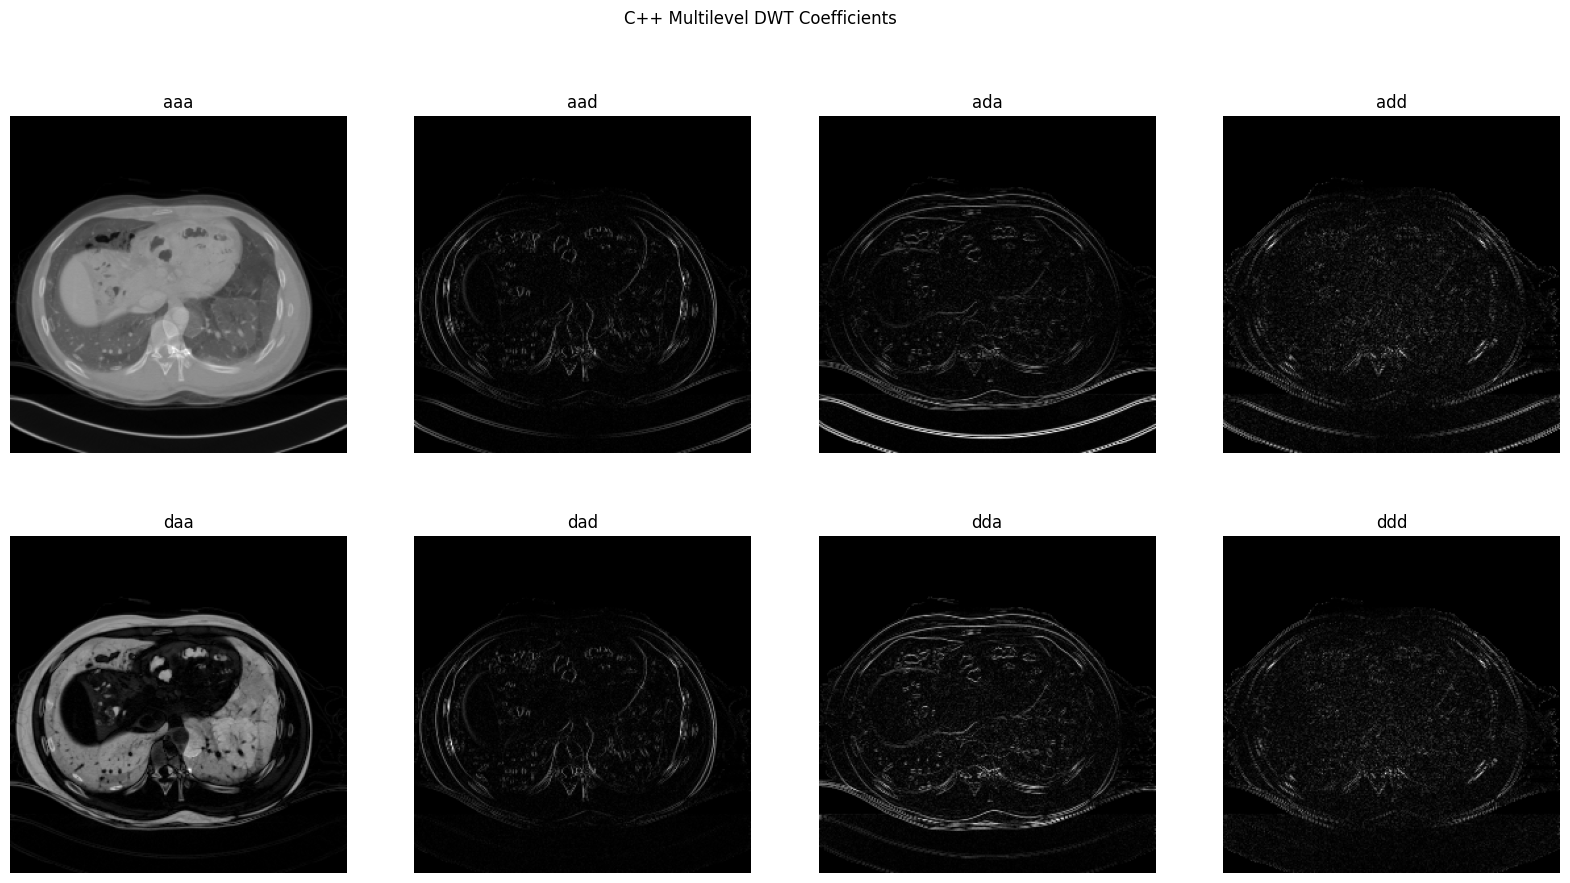

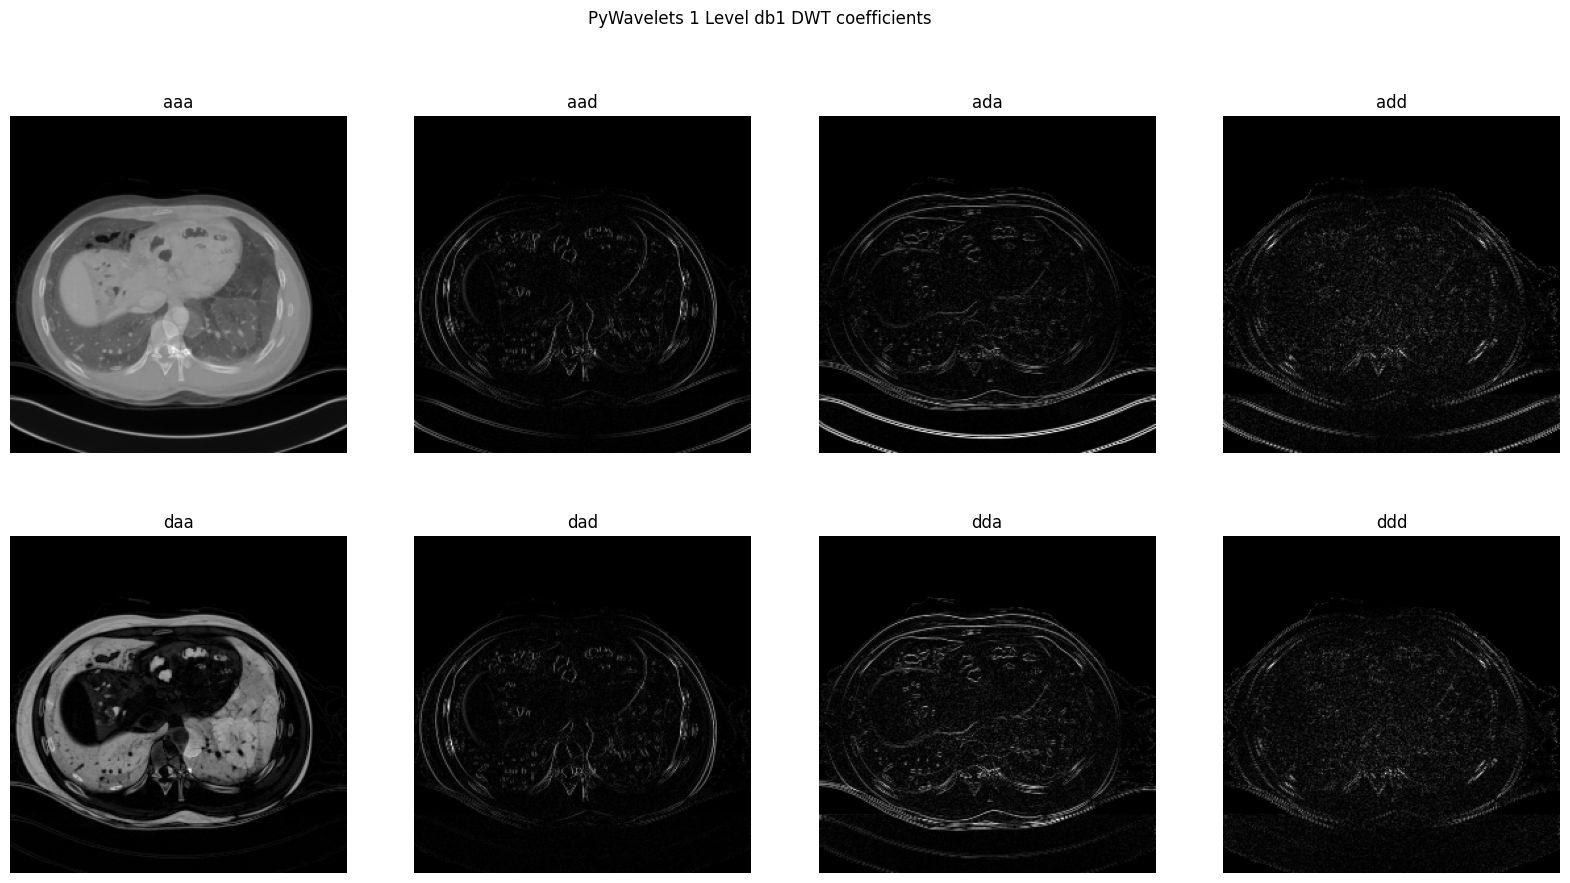

Subband aaa - MSE: 7.000854787515354e-15, Euclidean Distance: 0.00013376655988395214
Subband aad - MSE: 1.8880843069557507e-12, Euclidean Distance: 0.0021967224311083555
Subband ada - MSE: 2.846476851968427e-13, Euclidean Distance: 0.0008528363541699946
Subband add - MSE: 7.676084594343546e-12, Euclidean Distance: 0.004428959917277098
Subband daa - MSE: 2.698091316338802e-14, Euclidean Distance: 0.00026259818696416914
Subband dad - MSE: 9.529574395220064e-13, Euclidean Distance: 0.0015605814987793565
Subband dda - MSE: 1.051287488594739e-13, Euclidean Distance: 0.0005183148314245045
Subband ddd - MSE: 1.2319853253880964e-12, Euclidean Distance: 0.0017744022188708186


In [56]:
out_file = 'assignment-2/file/single_haar.bin'
# Open the volume from the .bin file
volume = open_bin_file(out_file)

# Get the wavelet coefficients
coeffs= get_coefficients(volume)

# Take the abs value of the coefficients for visualization
for key in coeffs:
    coeffs[key] = np.abs(coeffs[key])

# Plot the wavelet coefficients
plot_coefficients(coeffs)

# Convert the dictionary of coefficients to a numpy array
coeffs_cpp = np.array(list(coeffs.values()))

# pywave usage

wavelet = 'db1'                 #   --- usage ---
levels = 1                    #   --- usage ---

input_vol = vol_in  # input volume saved to bin file previously
coeffs_py = multi_level_3d_wavelet_transform(input_vol, wavelet, levels)

print_statistics(coeffs_py, coeffs_cpp)

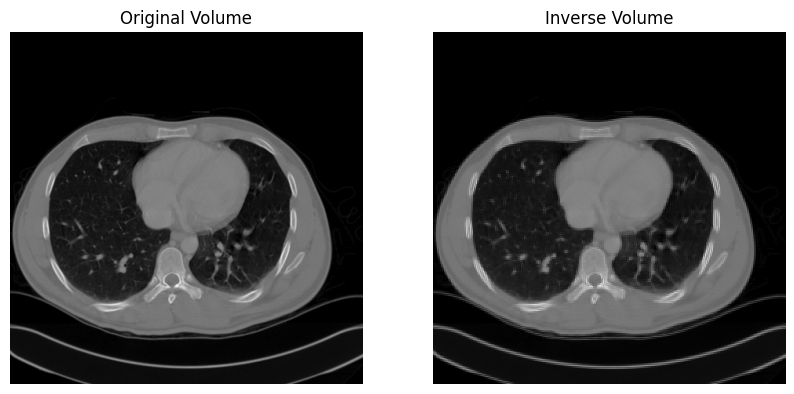

In [57]:
in_file = 'assignment-2/file/input.bin'
inv_file = 'assignment-2/file/inv_single_haar.bin'

# Open the volume from the .bin file
volume = open_bin_file(in_file)
# Get the inv_volume from the .bin file
inv_volume = open_bin_file(inv_file)

# Take the abs value of the volume for visualization
volume = np.abs(volume)
# Take the abs value of the inverse volume for visualization
inv_volume = np.abs(inv_volume)


# Plot the first slices side by side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(volume[30, :, :], cmap='gray')
plt.title('Original Volume')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(inv_volume[31, :, :], cmap='gray')
plt.title('Inverse Volume')
plt.axis('off')
plt.show()


